<a href="https://colab.research.google.com/github/ntraut/microdraw_winter_school/blob/main/MicroDraw_SquirrelMonkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is it like to be a squirrel monkey?**

## Analysis of open histological data using MicroDraw.
### HIBALL Winterschool workshop 2021

Katja Heuer, Nicolas Traut, Anibal Sólon & Roberto Toro

<table>
<tr valign="top">
<td><img width="400px" src="https://www.thealexandriazoo.com/images/animals/SquirrelMonkey.jpg" /></td>
<td><img width="400px" src="https://brains.anatomy.msu.edu/museum/brain/specimens/primates/squirrelmonk/brain/squirrelmonk6.jpg" /></td>
</tr>
</table>

This collab demonstrates how to programmatically obtain all annotations available for whole-brain histological datasets in MicroDraw.

The script also displays all annotations, and can synthesise them into a single histological volume. This allows, for example, to measure the volume of the different structures annotated.

In this example, data comes from the [Squirrel monkey project](https://microdraw.pasteur.fr/project/squirrelmonkey).

In this workshop, we will manually and collaboratively draw the pial surface of the cerebrum. Our aim will be to recover those annotations and produce a plot of the volume and surface for the cerebrum.

### 1 Manually and collaboratively draw the pial surface of the Squirrel Monkey brain

Each of us will draw a slice, and we will then analyse our collaborative work to compute basic parameters (surface area and volume).

We will use a framapad document (like Google doc but no need for account) to communicate and to tell each other which slices are we annotating.

Here is the URL of our framapad document: https://mensuel.framapad.org/p/squirrelmonkey

Depending on whether you have a tablet with a pen, a mouse or a trackpad, this will take us from 3 to 15 minutes – and also depending on the slice you chose ;)

### 2 Download and install the microdraw package

We will first install the `microdraw.py` module, which has several functions for accessing more easily data in the Microdraw website.

We will only use the most basic functions of `microdraw.py` (which is very much work in progress, especially concerning best practices, documentation, and code organisation... 🙃).

In [ ]:
%%bash
rm -r microdraw
git clone https://github.com/r03ert0/microdraw.py
mv microdraw.py microdraw
pip install -r microdraw/requirements.txt

Cloning into 'microdraw.py'...


### 2 Import libraries

Now that `microdraw.py` and its dependencies are installed, we can go back to Python and import them.

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sys.path.append("./microdraw")
from microdraw import microdraw as mic

### 3 Set project details

Although you can visualise and annotate individual datasets in Microdraw, the best way for collaborating is to create a Project. A project can have multiple datasets, and you can invite collaborators to work with you. Once you log in to Microdraw (using a GitHub account), you can see all the projects in which you are a collaborator in your User page.

For this tutorial, we have created a project called "[squirrelmonkey](https://microdraw.pasteur.fr/project/squirrelmonkey)", which contains a single dataset: Nissl stained slices from a Squirrel monkey, available from the Brain Museum (a project from the University of Wisconsin-Madison).

This project is open, but you can also create private projects. Private tokens require a token, which in our case will be just empty.

In [ ]:
# The project
project="squirrelmonkey"

# The dataset within the project
source="https://microdraw.pasteur.fr/squirrelmonkey_cor_cell/squirrelmonkey_cor_cell.json"

# The access token (empty for an open project)
token=""

### 4 Downloading and displaying annotations
We will first download and plot a single slice, to make sure everything is working.





In [ ]:
# we are downloading the first slice, slice = 0
sl = mic.download_all_regions_from_dataset_slice(source, project, 0, token)

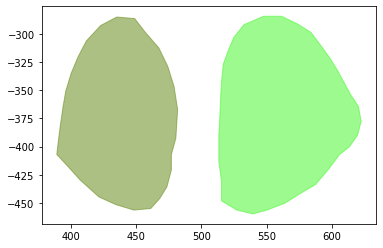

In [ ]:
# each slice can have multiple regions, each with a different label 
# (in our case, labels will be "Region 1", "Region 2", etc.)
regions = mic.get_regions_from_dataset_slice(sl)
for name, region in regions:
  color = mic.color_from_string(name)
  plt.fill(region[:, 0], -region[:, 1], c=color, alpha=0.5)

In [ ]:
# Now that we know that everything is working fine, we will download
# all the annotations made by your collaborators and you (should take less than a minute)
squirrelmonkey_slices = mic.download_all_regions_from_dataset(source, project, token)

100%|██████████| 65/65 [00:43<00:00,  1.48it/s]


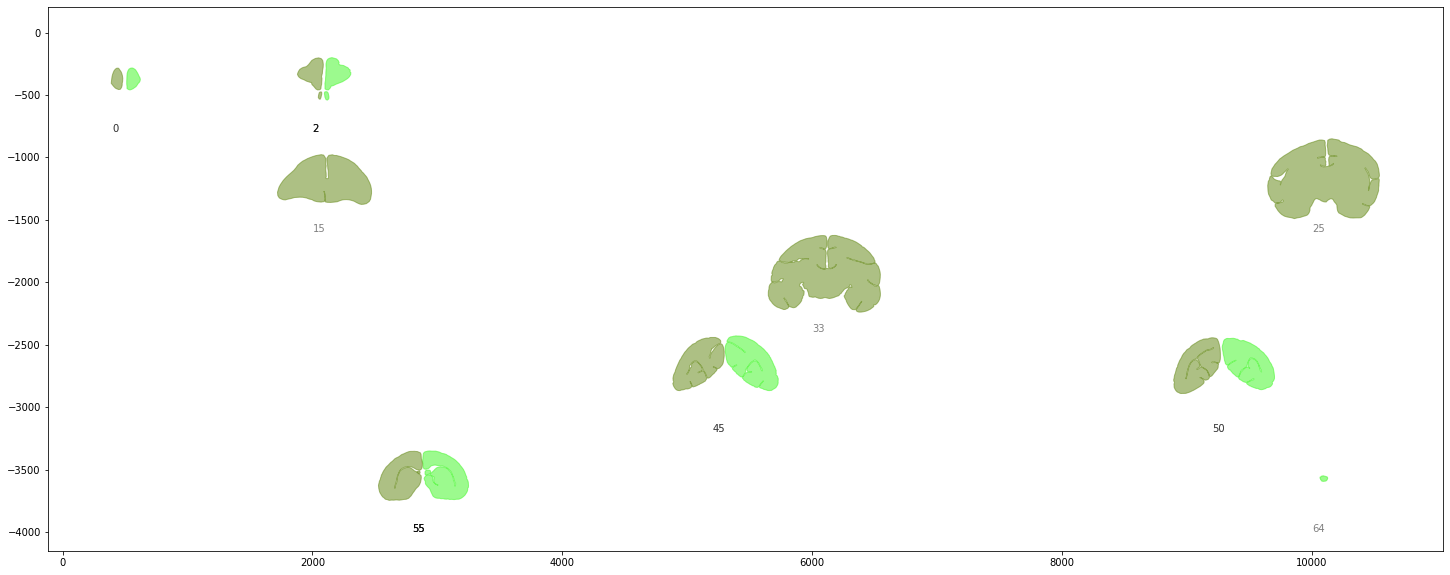

In [ ]:
# microdraw.py has a handy function for plotting all the slices in a dataset
# which you can use to see if there is any slice that was missing, or if
# the regions are all properly labelled. If that is not the case, you can get
# back to the Microdraw website, fix the error, come back here and rerun the
# download.
mic.draw_all_dataset(squirrelmonkey_slices)

### 5 Compute pial surface area and brain volume

Now that we have all the data, we will use it to compute surface area and brain volume. For that, we need to find out what is the resolution of our images, and the space between slices.

This is one brain slice. Its size is 720x541 pixels.

<img src="https://brains.anatomy.msu.edu/museum/brain/specimens/primates/squirrelmonk/sections/538squirlmonk_61672_6.jpg" />

Using GIMP or some other tool, you can measure the size of the scale bar in the image showing the total antero-posterior length of tha squirrel monkey brain, and the scale bar in a brain slice.

You also need to know that width of the annotation layer in MicroDraw is always 1000 units.

With those numbers, we can compute the scale factors we need:

In [ ]:
one_cm_in_px_slice = 280 # px/cm
one_svg_unit_in_px = 720/1000 # px/u
scaling_factor_in_cm = one_svg_unit_in_px/one_cm_in_px_slice

AP_length_in_px = 205 # px
one_cm_in_px_brain = 46 # px/cm
AP_length_in_cm = 205/406 # cm
total_number_of_slices = 65 # slices
inter_slice_space_in_cm = AP_length_in_px/one_cm_in_px_brain/total_number_of_slices

print("scaling_factor: %g cm"%(scaling_factor_in_cm))
print("inter_slice_space: %g cm"%(inter_slice_space_in_cm))

scaling_factor: 0.00257143 cm
inter_slice_space: 0.0685619 cm


In [ ]:
from shapely.geometry.polygon import Polygon

In [ ]:
# to check that everything is working, we will first compute
# the surface area and perimeter of the first region in the first
# slice of our dataset
name, region = regions[0]
poly = Polygon(region)
region_volume = poly.area * scaling_factor_in_cm**2 * inter_slice_space_in_cm
region_surface_area = poly.length * scaling_factor_in_cm

print("region_volume:", region_volume)
print("region_surface_area:", region_surface_area)

region_volume: 0.006357199115888796
region_surface_area: 1.1712592510370772


In [ ]:
# now we do that for all the dataset
total_volume = 0
total_surface_area = 0
for sl in squirrelmonkey_slices:
  for _, region in regions:
    poly = Polygon(region)
    region_volume = poly.area * scaling_factor_in_cm**2 * inter_slice_space_in_cm
    region_surface_area = poly.length * scaling_factor_in_cm
    total_volume += region_volume
    total_surface_area += region_surface_area

print("total_volume:", total_volume)
print("total_surface_area:", total_surface_area)


total_volume: 0.046779072340436594
total_surface_area: 9.035293134687818


### 6 Conclusion

That's it for today! Now you know how to use MicroDraw and microdraw.py to work collaboratively on histological data. As you see, there is a lot that you can do only from the Web browser.

Let's stay in touch! We are happy to show you our projects, to help you set up your own projects. We'll be delighted if you would like to help us improve MicroDraw either by coding or by testing it.

Thank you all! 😊 